In [37]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
#import julia as jl

In [38]:
data = pd.read_csv('DummiesV2.csv')

In [39]:
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import normalize
from sklearn.model_selection import train_test_split
targets = ['Indemne', 'Blessé léger', 'Blessé hospitalisé', 'Tué']
X = data.drop(targets, axis=1)
Y = data[targets].values.argmax(axis=1) # cela réordonne bien les modalités puisque `targets` est ordonnée.
X_train, X_test,Y_train, Y_test = train_test_split(X, Y, test_size=0.3,stratify=Y, random_state=0)

In [40]:
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import StratifiedKFold
from sklearn.feature_selection import RFECV

In [41]:
def plot_confusion_matrix(matrix, classes,
                          normalize=False,
                          cmap=plt.cm.Blues,
                          title=None):

    if normalize:
        matrix = matrix.astype('float') / matrix.sum(axis=1)[:, np.newaxis]
        title = title if title else "Normalized confusion matrix"
    else:
        title = title if title else "Raw confusion matrix"

    sns.set_style('ticks')
    res = sns.heatmap(matrix,
                      cmap=cmap,
                      cbar=True,
                      square=True,
                      annot=True)

    for _, spine in res.spines.items():
        spine.set_visible(True)

    plt.title(title)
    tick_marks = np.arange(len(classes)) + .5
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes, rotation=0)

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.show()

In [42]:
import os
def update_fit(estimator,X_train,Y_train,name,retrain=False):
    if not os.path.isfile(name) or retrain:
        fited=estimator.fit(X_train, Y_train)
        jl.dump(fited, name)
    else:
        fited = jl.load(name)
    return(fited)

### Comparer les performances: séléctionnées manuelement, pour d'autres algorithmes et sans selection de variables après avoir choisir le nb de voisin optimal par CV

### D'abord sans selection de variables

In [43]:
knn = KNeighborsClassifier(weights='uniform',p=2)
knn

KNeighborsClassifier()

1ère itération, on cherche un ordre de grandeurpour k, il y'a maximmum autant de voisins que le min d'observation des échantillons -> environ 40000 

In [44]:
from sklearn.model_selection import GridSearchCV
# on vérifie sur de grandes valeurs que l'accuracy est mauvaise malheureusement, algo très lent pour k grand a planté
# de plus pour k très grand on peut supposer sous apprentissage
param_k = dict(n_neighbors= np.arange(1,160,10))
knn_1 = GridSearchCV(knn, param_k, cv=2, verbose=3,refit=True)
knn_1=update_fit(knn_1,X_train,Y_train,'FirstGS_KNN_without_selec').best_estimator_

In [45]:
knn_1


KNeighborsClassifier(n_neighbors=51)

On fait alors la deuxième itération entre 1 et 51 par pas de 2 :


In [46]:
param_k = dict(n_neighbors= np.arange(2,52 ,2))
knn_2 = GridSearchCV(knn, param_k, cv=2, verbose=3,refit=True)
knn_2 = update_fit(knn_2,X_train,Y_train,'SecondGS_KNN_without_selec').best_estimator_

In [47]:
knn_2

KNeighborsClassifier(n_neighbors=36)

In [83]:
from sklearn.metrics import accuracy_score
y_hat_1=knn_2.predict(X_test)

In [84]:
print('Accuracy :', accuracy_score(Y_test,y_hat_1))

Accuracy : 0.6289422061264524


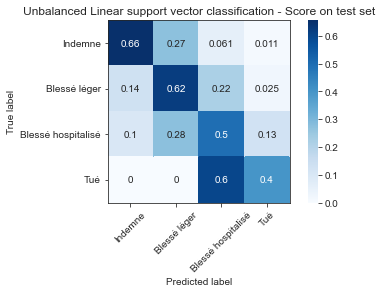

In [85]:
from sklearn import metrics
conf = metrics.confusion_matrix(y_hat_1, Y_test)
plot_confusion_matrix(conf, classes=targets, normalize=True, title='Unbalanced Linear support vector classification - Score on test set');


## En raison des longs temps de calcul, on considera le même k*=36

### Idée 1: on supprime les variables qui ont une corrélation inf < 0,005 en valeure absolue

In [78]:
from sklearn import base
knn = base.clone(knn_2, safe=True)

In [54]:
z=list(data.drop(targets,axis=1).columns)

In [69]:
x=data.corr()

In [87]:
delete=x.loc[targets,z].apply(np.abs).sum(axis=0).sort_values(ascending=True).index.to_list()
# on veut supprimer 30% des variables par exemple soit 50
delete=delete[0:66]+targets


In [88]:
selected=data.drop(columns=delete).columns.to_list()

In [89]:
knn.fit(X_train[selected],Y_train)


KNeighborsClassifier(n_neighbors=36)

In [90]:
y_hat_selected= knn.predict(X_test[selected])

Accuracy : 0.6289422061264524


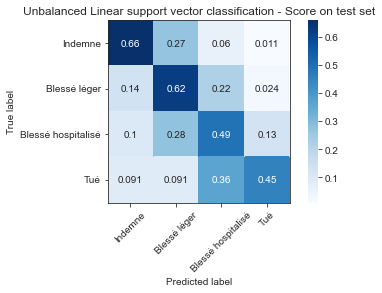

In [86]:
print('Accuracy :', accuracy_score(Y_test,y_hat))
conf = metrics.confusion_matrix(y_hat_selected, Y_test)
plot_confusion_matrix(conf, classes=targets, normalize=True, title='Unbalanced Linear support vector classification - Score on test set');
 

### Idée 2: utiliser les variables sélectionées par RFECV pour la régression logistique 

In [12]:
# je n'ai pas la liste ce serait plus pratique ce mettre tout dans un notebook puis compiler ces deux cellules 
#selected_LR=[] 

SyntaxError: invalid syntax (<ipython-input-12-c9170aa76789>, line 1)

### Idée 3: Utiliser les variables aléatoires sélectionnées par les RF

In [13]:
#selected_RF=

SyntaxError: invalid syntax (<ipython-input-13-b61aaf10505c>, line 1)